<a href="https://colab.research.google.com/github/joaochenriques/IST---Marine-Currents-and-Tidal-Energy/blob/main/Tidal_Stream/BladeElementMethod/BladeDesign_V10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import subprocess
import pandas as pd
import pathlib
import numpy as np
from scipy.optimize import minimize, root_scalar
from copy import deepcopy

def cmdcall( cmd, verbose = False ):
    output = subprocess.getoutput( cmd )
    if verbose: print(output)

if not pathlib.Path("mpl_utils.py").exists():
  cmdcall( "curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py" )

import matplotlib.pyplot as mpl
import mpl_utils as mut
mut.config_plots()

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

In [2]:
rad2deg = 180/np.pi
deg2rad = np.pi/180

def SinDist( i: int, n: int, ang0_deg: float = 0 ) -> float:
    if i == n-1: return 1
    if i == 0: return 0
    csi0 = ang0_deg * deg2rad
    dcsi = ( np.pi - 2 * csi0 ) * i / ( n-1 )
    return ( ( np.cos( np.pi - csi0 - dcsi ) + 1.0 ) * 0.5 )

In [79]:
class Data:

    def __init__( self, λ_hub, λ_tip, n, linear=True ):
        self.λ_hub   = λ_hub
        self.λ_tip   = λ_tip

        if linear:
            self.λ_vec   = np.linspace( λ_hub, λ_tip, n )
        else:
            self.λ_vec   = np.zeros( n )
            for i in range( n ):
                self.λ_vec[i] = (self.λ_tip - self.λ_hub ) * SinDist( n-1-i, n ) + self.λ_hub

        self.n = n
        self.a_vec   = np.zeros( n )
        self.ap_vec  = np.zeros( n )
        self.k_vec  = np.zeros( n )
        self.ϕ0_vec   = np.zeros( n )
        self.σ_vec = np.zeros( n )
        self.CP_vec  = np.zeros( n )
        self.CP_tip  = 0.0

        self.α_vec  = np.zeros( n )
        self.CL_vec  = np.zeros( n )
        self.CD_vec  = np.zeros( n )


In [12]:
_λ_hub = 0.5
_λ_tip = 5.0
_dλ = 0.5

n = int( ( _λ_tip - _λ_hub ) / _dλ + 0.5 ) + 1

dti = Data( _λ_hub, _λ_tip, n ) # data for inviscid flow

print( f'r_hub / R_tip = {_λ_hub/_λ_tip:0.3f}' )
dti.λ_vec

r_hub / R_tip = 0.100


array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [13]:
class MyAirfoil:

    α_opt = 6.08178 * deg2rad

    @staticmethod
    def data( α, Wm = np.nan ):
        # max( CL/CD ) -> α = 6.08178
        α *= rad2deg
        # CL = 0.368 + 0.094 * α
        # CD = 3.31333E-3 + (8.63333E-5 + 3.51666E-5 * α) * α
        CL, CD = 1.5, 0.014
        return CL, CD

In [56]:
class DU91W2250:

    α_opt = 8.5 * deg2rad

    def __init__( self ):
        df = pd.read_excel('DU91W2250_polar.xlsx', sheet_name='Sheet1')
        self.alpha = df['alpha'].to_numpy()
        self.CL = df['CL'].to_numpy()
        self.CD = df['CD'].to_numpy()

    def data( self, α, Wm = np.nan ):
        CL = np.interp( α, self.alpha, self.CL )
        CD = np.interp( α, self.alpha, self.CD )
        return CL, CD

MyAirfoil = DU91W2250()

In [59]:
Z = 3
α_des  = MyAirfoil.α_opt * deg2rad
CL_des, CD_des = MyAirfoil.data( α_des )
CL_des, CD_des

(np.float64(0.4229309059031143), np.float64(0.009160258924806819))

## Glauert optimal distribution

C_P = 0.5675 -> Glauert


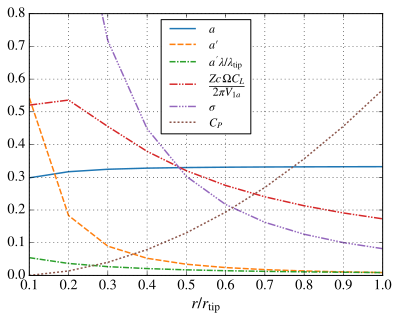

In [60]:
def f(y):
    return -64/5 * y**5 - 72 * y**4 - 124 * y**3 - 38 * y**2 + 63 * y + 12 * np.log(y) + 4 / y

def Integral_f( y2, y1, λ_tip ):
    return 8 / ( 729 * λ_tip**2 ) * ( f(y2) - f(y1) )

CP = 0

for i, λ in enumerate( dti.λ_vec ):

    func = lambda a: 16 * a**3 - 24 * a**2 + 3 * ( 3 - λ**2 ) * a + ( λ**2 - 1 )
    a = root_scalar(func, bracket=[ 1.0/4.0, 1.0/3.0 ], method='brentq' ).root
    ap = ( 1.0 - 3 * a ) / ( 4 * a - 1 )

    ϕ0 = np.arctan( ( 1 - a ) / ( 1 + ap ) / λ )
    σCL  = 4.0 * ap * λ / np.sqrt( ( 1.0 - a )**2 + ( 1.0 + ap )**2 * λ**2 )

    dti.a_vec[i] = a
    dti.ap_vec[i] = ap
    dti.ϕ0_vec[i] = ϕ0
    dti.σ_vec[i] = σCL / CL_des

    if i > 0:
        dti.CP_vec[i] = CP = CP + Integral_f( 1 - 3*dti.a_vec[i], 1 - 3*dti.a_vec[i-1], dti.λ_tip )

x_vec = dti.λ_vec / dti.λ_tip

mpl.plot( x_vec, dti.a_vec,  label = r"$a$" )
mpl.plot( x_vec, dti.ap_vec, label = r"$a\prime$" )
mpl.plot( x_vec, dti.ap_vec*dti.λ_vec/dti.λ_tip, label = r"$a'\lambda/\lambda_\mathrm{tip}$" )
mpl.plot( x_vec, dti.σ_vec* CL_des *dti.λ_vec, label = r"$\dfrac{Zc\,\Omega C_L}{2\pi V_{1a}}$" )
mpl.plot( x_vec, dti.σ_vec, label = r"$\sigma$" )
mpl.plot( x_vec, dti.CP_vec, label = r"$C_P$" )

mpl.xlabel( r"$r/r_\mathrm{tip}$")
mpl.legend( loc="upper center", fontsize=12, handlelength=2.8, \
            labelspacing=0.4 )
mpl.grid()
mpl.ylim( ( 0.0, 0.8 ) )
mpl.savefig( "InductionFactors.pdf" )
print( f"C_P = {dti.CP_vec[-1]:.4f} -> Glauert" )

In [61]:
df = pd.DataFrame( { r"$\lambda$": dti.λ_vec,
                     r"$a$": dti.a_vec,
                     r"$a'$": dti.ap_vec,
                     r"$\phi_0$": dti.ϕ0_vec*rad2deg,
                     r"$C_P$": dti.CP_vec,
                     r"$\frac{Zc\,\Omega C_L}{2\pi V_{1a}}$": dti.σ_vec*CL_des*dti.λ_vec,
                     r"$\sigma$": dti.σ_vec
                    } )

# print( df.to_latex(index=False,
#        formatters=["{:.2f}".format,"{:.5f}".format,"{:.5f}".format, \
#                    "{:.2f}".format,"{:.3f}".format,"{:.4f}".format]
# ))
df

,$\lambda$,$a$,$a'$,$\phi_0$,$C_P$,"$\frac{Zc\,\Omega C_L}{2\pi V_{1a}}$",$\sigma$
0,0.5,0.298346,0.542757,42.289966,0.000000,0.520502,2.461405
1,1.0,0.316987,0.183013,30.000000,0.013726,0.535898,1.267106
2,1.5,0.324456,0.089419,22.460045,0.040050,0.455123,0.717411
3,2.0,0.327896,0.052354,17.710034,0.078896,0.379134,0.448222
4,2.5,0.329700,0.034191,14.534273,0.130075,0.320023,0.302672
5,3.0,0.330747,0.024018,12.289966,0.193449,0.275006,0.216746
6,3.5,0.331404,0.017772,10.630264,0.268931,0.240267,0.162314
7,4.0,0.331842,0.013671,9.357496,0.356457,0.212911,0.125855
8,4.5,0.332146,0.010837,8.352538,0.455988,0.190926,0.100319
9,5.0,0.332367,0.008799,7.539955,0.567493,0.172928,0.081776


## Computing the turbine blade (Glauert's solution)

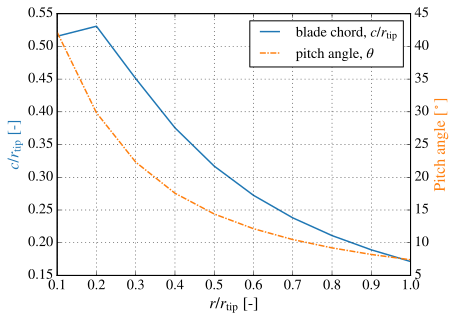

In [62]:
σ_factor = 2.0 * np.pi / Z

θ_vec = dti.ϕ0_vec - α_des
cR_vec = dti.σ_vec * σ_factor *  dti.λ_vec / dti.λ_tip
rR_vec = dti.λ_vec / dti.λ_tip

ax1 = mpl.gca()
ax1.plot( rR_vec, cR_vec, mut.linecolors[0], label=r"blade chord, $c/r_\mathrm{tip}$" )
ax1.set_ylabel( r"$c/r_\mathrm{tip}$ [-]", color=mut.linecolors[0] )
ax1.set_xlabel( r"$r/r_\mathrm{tip}$ [-]")
ax1.grid()
# ax1.set_ylim( 0, 0.25 )

ax2 = mpl.gca().twinx()
ax2.plot( rR_vec, θ_vec * rad2deg, mut.linecolors[1], \
          dashes=mut.linestyles[2], label=r'pitch angle, $\theta$' )
ax2.tick_params(axis='y' )
ax2.set_ylabel( r"Pitch angle [$^\circ$]", color=mut.linecolors[1] )
# ax2.set_ylim( 0, 50 )
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right' )

mpl.savefig( "TurbineBlade.pdf" )

In [63]:
def tip_loss( a, ap, ϕ, ϕ0, λ, λtip ):
    ff = 0.5 * Z * ( λtip / λ - 1 ) * np.sqrt( 1 + ( λ / (1-a) )**2 )
    rr =  np.max( ( 2.0 / np.pi * np.arccos( np.exp( -ff ) ), 1E-3 ) )

    # ff = 0.5 * Z * λtip / λ / np.tan( ϕ ) - 0.5
    # rr =  2.0 / np.pi * np.arccos( np.cosh( λtip / λ* ff ) / np.cosh( ff ) )
    # print( ff, np.cosh( λtip / λ* ff ), np.cosh( ff ), rr )
    return rr

In [64]:
# The initial viscous solution is the invisc flow results
dtv = deepcopy( dti ) # deepcopy avoids references

for i, λ in enumerate( dti.λ_vec ):

    ϕ = np.atan( 1 / λ )
    a = dti.a_vec[i]
    ap = dti.ap_vec[i]
    σ = dti.σ_vec[i]

    for j in range( 100 ):

        a_mo = a
        ap_mo = ap

        ϕ0 = np.atan2( ( 1 - a ), ( 1 + ap ) * λ )
        cosϕ0 = np.cos( ϕ0 )
        sinϕ0 = np.sin( ϕ0 )

        Ca = CL_des * cosϕ0 + CD_des * sinϕ0
        Ct = CL_des * sinϕ0 - CD_des * cosϕ0

        a  = σ * Ca / ( 4 * sinϕ0**2 + σ * Ca )
        ap = σ * Ct / ( 4 * sinϕ0*cosϕ0 - σ * Ct )

        if np.abs( a - a_mo ) < 1E-6 and np.abs( ap - ap_mo ) < 1E-6:
            break

    k = tip_loss( a, ap, ϕ, ϕ0, λ, dtv.λ_tip )

    dtv.a_vec[i] = a
    dtv.ap_vec[i] = ap
    dtv.k_vec[i] = k
    dtv.σ_vec[i] = dti.σ_vec[i] * k

# integrate CP using trapezoidal rule
CP = 0
fct = 8 / dtv.λ_tip**2
for i in range( 1, len( dti.λ_vec ) ):
    k = i - 1
    d_λ = -( dtv.λ_vec[i] - dtv.λ_vec[k] )
    f_k = dtv.k_vec[k] * dtv.ap_vec[k] * ( 1 - dtv.a_vec[k] ) * dtv.λ_vec[k]**3
    f_i = dtv.k_vec[i] * dtv.ap_vec[i] * ( 1 - dtv.a_vec[i] ) * dtv.λ_vec[i]**3
    dtv.CP_vec[i] = CP = CP + fct * 0.5 * ( f_i + f_k ) * d_λ

print( f"C_P = {CP:.4f} -> Viscous flow" )

C_P = -0.4272 -> Viscous flow


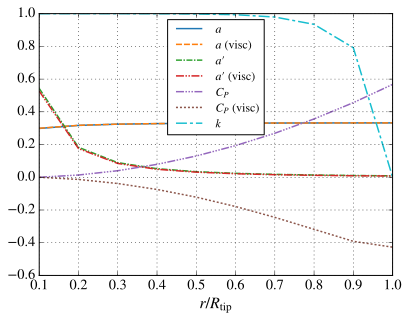

In [65]:
rR_vec = dtv.λ_vec / dtv.λ_tip

mpl.plot( rR_vec, dti.a_vec,  label = r"$a$" )
mpl.plot( rR_vec, dtv.a_vec,  label = r"$a$ (visc)" )
mpl.plot( rR_vec, dti.ap_vec, label = r"$a\prime$" )
mpl.plot( rR_vec, dtv.ap_vec, label = r"$a\prime$ (visc)" )
mpl.plot( rR_vec, dti.CP_vec, label = r"$C_P$" )
mpl.plot( rR_vec, dtv.CP_vec, label = r"$C_P$ (visc)" )
mpl.plot( rR_vec, dtv.k_vec, label = r"$k$" )

mpl.xlabel( r"$r/R_\mathrm{tip}$")
mpl.legend( loc="upper center", fontsize=12, handlelength=2.8, \
            labelspacing=0.4 )
mpl.grid()
# mpl.ylim( ( 0.0, 1.05 ) )
mpl.savefig( "InductionFactors.pdf" )

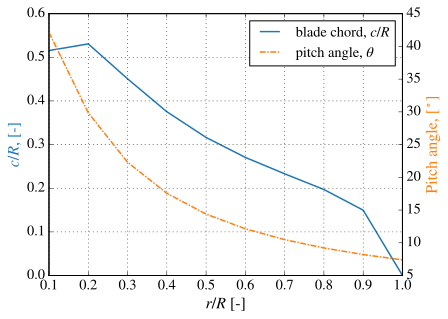

In [66]:
θ_vec = dtv.ϕ0_vec - α_des
cR_vec = dtv.σ_vec * σ_factor *  dtv.λ_vec / dtv.λ_tip
rR_vec = dtv.λ_vec / dtv.λ_tip

mpl.figure(4)
ax1 = mpl.gca()
ax1.plot( rR_vec, cR_vec, mut.linecolors[0], label=r"blade chord, $c/R$" )
ax1.set_ylabel( r"$c/R$, [-]", color=mut.linecolors[0] )
ax1.set_xlabel( r"$r/R$ [-]")
ax1.grid()
# ax1.set_ylim( 0, 0.25 )

ax2 = mpl.gca().twinx()
ax2.plot( rR_vec, θ_vec * rad2deg, mut.linecolors[1], \
          dashes=mut.linestyles[2], label=r'pitch angle, $\theta$' )
ax2.tick_params(axis='y' )
ax2.set_ylabel( r"Pitch angle, [$^\circ$]", color=mut.linecolors[1] )
# ax2.set_ylim( 0, 50 )
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right' )

mpl.savefig( "TurbineBlade_visc.pdf" )

In [67]:
df = pd.DataFrame( { r"$\lambda$": dtv.λ_vec,
                     r"$a$": dtv.a_vec,
                     r"$a'$": dtv.ap_vec,
                     r"$\phi_0$": dtv.ϕ0_vec*rad2deg,
                     r"$\frac{Zc\,\Omega C_L}{2\pi V_{1a}}$": dtv.σ_vec*CL_des*dtv.λ_vec,
                     r"$\sigma$": dtv.σ_vec
                    } )

# print( df.to_latex(index=False,
#        formatters=["{:.2f}".format,"{:.5f}".format,"{:.5f}".format, \
#                    "{:.2f}".format,"{:.3f}".format,"{:.4f}".format]
# ))
df

,$\lambda$,$a$,$a'$,$\phi_0$,"$\frac{Zc\,\Omega C_L}{2\pi V_{1a}}$",$\sigma$
0,0.5,0.299618,0.526452,42.289966,0.520502,2.461405
1,1.0,0.317498,0.175292,30.000000,0.535890,1.267087
2,1.5,0.324690,0.084418,22.460045,0.455066,0.717321
3,2.0,0.328019,0.048659,17.710034,0.378928,0.447978
4,2.5,0.329772,0.031259,14.534273,0.319402,0.302084
5,3.0,0.330794,0.021586,12.289966,0.273234,0.215349
6,3.5,0.331436,0.015694,10.630264,0.235294,0.158955
7,4.0,0.331864,0.011856,9.357496,0.198969,0.117613
8,4.5,0.332164,0.009226,8.352538,0.151166,0.079428
9,5.0,0.332381,0.007350,7.539955,0.000173,0.000082


In [91]:
λ_off = 5

rat = λ_off / _λ_tip
dta = Data( _λ_hub * rat, _λ_tip * rat, dtv.n )

fr = 0.5
omfr = 1 - fr
Found = False

for i, λ in enumerate( dta.λ_vec ):
    rR = λ / dta.λ_tip

    # if i > 6:
    #     break

    if i == 0:
        a  = dtv.a_vec[i]
        ap = dtv.ap_vec[i]

    σ  = dtv.σ_vec[i]

    # print( f'i = {i}, λ = {λ}' )

    for j in range( 400 ):

        a_mo = a
        ap_mo = ap

        ϕ0 = np.atan2( ( 1 - a ), ( 1 + ap ) * λ )
        cosϕ0 = np.cos( ϕ0 )
        sinϕ0 = np.sin( ϕ0 )

        α = ϕ0 - θ_vec[i]
        CL, CD = MyAirfoil.data( α )

        Ca = CL * cosϕ0 + CD * sinϕ0
        Ct = CL * sinϕ0 - CD * cosϕ0

        a  = σ * Ca / ( 4 * sinϕ0**2 + σ * Ca )
        ap = σ * Ct / ( 4 * sinϕ0*cosϕ0 - σ * Ct )

        a = fr * a + a_mo * omfr
        ap = fr * ap + ap_mo * omfr

        error = np.max( (np.abs( a - a_mo ), np.abs( ap - ap_mo ) ) )

        if error < 1E-6:
            Found = True
            break

    if not Found:
        print( f'ERROR max = {error:.4E}' )

    print( f'\ti = {i}, ϕ0 = {ϕ0*rad2deg:.6f}, α = {α*rad2deg:.6f} a = {a:.6f}, ap = {ap:.6f}, r/R = {rR:.6f}' )

    k = tip_loss( a, ap, ϕ, ϕ0, λ, dtv.λ_tip )

    dta.a_vec[i] = a
    dta.ap_vec[i] = ap
    dta.k_vec[i] = k
    dta.σ_vec[i] = σ

    dta.α_vec[i] = α
    dta.CL_vec[i] = CL
    dta.CD_vec[i] = CD

# integrate CP using trapezoidal rule
CP = 0
fct = 8 / dtv.λ_tip**2
for i in range( 1, len( dta.λ_vec ) ):
    k = i - 1
    d_λ = -( dta.λ_vec[i] - dta.λ_vec[k] )
    f_k = dta.k_vec[k] * dta.ap_vec[k] * ( 1 - dta.a_vec[k] ) * dta.λ_vec[k]**3
    f_i = dta.k_vec[i] * dta.ap_vec[i] * ( 1 - dta.a_vec[i] ) * dta.λ_vec[i]**3
    dtv.CP_vec[i] = CP = CP + fct * 0.5 * ( f_i + f_k ) * d_λ

print( f"C_P = {CP:.4f} -> Viscous flow" )

	i = 0, ϕ0 = 42.507182, α = 0.365569 a = 0.300236, ap = 0.526932, r/R = 0.100000
	i = 1, ϕ0 = 30.127755, α = 0.276108 a = 0.317887, ap = 0.175393, r/R = 0.200000
	i = 2, ϕ0 = 22.540233, α = 0.228541 a = 0.324875, ap = 0.084442, r/R = 0.300000
	i = 3, ϕ0 = 17.769168, α = 0.207487 a = 0.327875, ap = 0.048650, r/R = 0.400000
	i = 4, ϕ0 = 14.594430, α = 0.208510 a = 0.328738, ap = 0.031215, r/R = 0.500000
	i = 5, ϕ0 = 12.386426, α = 0.244813 a = 0.327002, ap = 0.021476, r/R = 0.600000
	i = 6, ϕ0 = 10.845056, α = 0.363146 a = 0.319138, ap = 0.015431, r/R = 0.700000
	i = 7, ϕ0 = 9.889987, α = 0.680845 a = 0.294787, ap = 0.011215, r/R = 0.800000
	i = 8, ϕ0 = 9.641996, α = 1.437811 a = 0.229719, ap = 0.007547, r/R = 0.900000
	i = 9, ϕ0 = 11.307336, α = 3.915734 a = 0.000227, ap = 0.000008, r/R = 1.000000
C_P = -0.4194 -> Viscous flow


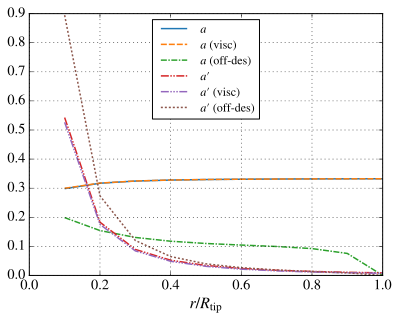

In [87]:
rR_vec = dta.λ_vec / dta.λ_tip

mpl.plot( rR_vec, dti.a_vec,  label = r"$a$" )
mpl.plot( rR_vec, dtv.a_vec,  label = r"$a$ (visc)" )
mpl.plot( rR_vec, dta.a_vec,  label = r"$a$ (off-des)" )
mpl.plot( rR_vec, dti.ap_vec, label = r"$a\prime$" )
mpl.plot( rR_vec, dtv.ap_vec, label = r"$a\prime$ (visc)" )
mpl.plot( rR_vec, dta.ap_vec, label = r"$a\prime$ (off-des)" )
# mpl.plot( rR_vec, dti.CP_vec, label = r"$C_P$" )
# mpl.plot( rR_vec, dtv.CP_vec, label = r"$C_P$ (visc)" )
# mpl.plot( rR_vec, dtv.k_vec, label = r"$k$" )

mpl.xlabel( r"$r/R_\mathrm{tip}$")
mpl.legend( loc="upper center", fontsize=12, handlelength=2.8, \
            labelspacing=0.4 )
mpl.grid()
# mpl.ylim( ( 0.0, 1.05 ) )

In [89]:
df = pd.DataFrame( { r"$\lambda$": dta.λ_vec,
                     r"$a$": dta.a_vec,
                     r"$a'$": dta.ap_vec,
                     r"$\phi_0$": dta.ϕ0_vec*rad2deg,
                     r"$\kappa$": dta.k_vec,
                     r"$\sigma$": dta.σ_vec,
                     r"$\alpha$": dta.α_vec*rad2deg,
                     r"$C_L$": dta.CL_vec,
                     r"$C_D$": dta.CD_vec,
                    } )

# print( df.to_latex(index=False,
#        formatters=["{:.2f}".format,"{:.5f}".format,"{:.5f}".format, \
#                    "{:.2f}".format,"{:.3f}".format,"{:.4f}".format]
# ))
df

,$\lambda$,$a$,$a'$,$\phi_0$,$\kappa$,$\sigma$,$\alpha$,$C_L$,$C_D$
0,0.3,0.198738,0.894653,0.0,1.000000,2.461405,12.507421,0.450498,0.009182
1,0.6,0.154313,0.273523,0.0,0.999999,1.267087,18.049211,0.462859,0.009192
2,0.9,0.130589,0.120196,0.0,0.999966,0.717321,18.461448,0.463779,0.009192
3,1.2,0.117616,0.064834,0.0,0.999790,0.447978,17.065288,0.460665,0.009190
4,1.5,0.109801,0.039848,0.0,0.999331,0.302084,15.328498,0.456791,0.009187
5,1.8,0.104404,0.026672,0.0,0.998400,0.215349,13.714459,0.453191,0.009184
6,2.1,0.099502,0.018814,0.0,0.996679,0.158955,12.343785,0.450133,0.009182
7,2.4,0.092279,0.013458,0.0,0.993559,0.117613,11.256156,0.447707,0.009180
8,2.7,0.075612,0.008865,0.0,0.987678,0.079428,10.540833,0.446112,0.009178
9,3.0,0.000088,0.000009,0.0,0.973051,0.000082,11.041668,0.447229,0.009179
